In [1]:
# Import required packages
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from datetime import datetime, timedelta
import xarray as xr
import rasterio as rio
import rioxarray
import geopandas as gpd
import time
from glob import glob
import scipy.signal
from mintpy.utils import readfile, writefile, utils as ut
from mintpy import view
from pathlib import Path

In [2]:
mintpy_path = '/home/jovyan/ffits/nbs/imja/proc_DT121/mintpy'
data_path = '/home/jovyan/ffits/nbs/imja/proc_DT121'

In [ ]:
# # rename files with unique names
# for path in glob(f'{data_path}/*/merged/'):
#     os.chdir(path)
#     primary = path[39:47]
#     secondary = path[48:56]
#     print(f'working on {primary}-{secondary}')
#     !mv $f'{primary}_{secondary}_range_offsets_phase' range_offsets_phase
#     !mv $f'{primary}_{secondary}_range_offsets_phase.xml' range_offsets_phase.xml

## crop to common extent

In [ ]:
def get_common_overlap(file_list):
    """Get the common overlap of  a list of GeoTIFF files
    
    Arg:
        file_list: a list of GeoTIFF files
    
    Returns:
         [ulx, uly, lrx, lry], the upper-left x, upper-left y, lower-right x, and lower-right y
         corner coordinates of the common overlap
    """
    
    corners = [gdal.Info(str(raster), format='json')['cornerCoordinates'] for raster in file_list]

    ulx = max(corner['upperLeft'][0] for corner in corners)
    uly = min(corner['upperLeft'][1] for corner in corners)
    lrx = min(corner['lowerRight'][0] for corner in corners)
    lry = max(corner['lowerRight'][1] for corner in corners)
    return [ulx, uly, lrx, lry]

In [ ]:
def clip_products_to_common_overlap(data_path, overlap):
    """Clip all GeoTIFF files to their common overlap
    
    Args:
        data_dir:
            directory containing the GeoTIFF files to clip
        overlap:
            a list of the upper-left x, upper-left y, lower-right-x, and lower-tight y
            corner coordinates of the common overlap
    Returns: None
    """
    
    files_for_mintpy = ['_range_offsets_phase']

    for extension in files_for_mintpy:
        print(f'working on {extension}') 
        for file in data_path.rglob(f'*{extension}'):

            dst_file = file.parent / f'{file.stem}_clipped{file.suffix}.tif'

            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)

In [ ]:
# # identify and crop to common overlap
# print('identifying common overlap')
# offset_files = Path(data_path).glob('*/merged/*_range_offsets_phase')
# overlap = get_common_overlap(offset_files)
# print('clipping to common overlap')
# clip_products_to_common_overlap(Path(data_path), overlap)

## Mintpy

In [3]:
# generate metadata file
lines = [f'{os.path.split(path)[-1]} {path[39:47]} {path[48:56]}\n' for path in glob(f'{data_path}/*/merged/*range_offsets_phase_clipped.tif')]
lines.sort()
with open(f'{data_path}/metadata.txt', 'w') as f:
    f.writelines(lines)

In [4]:
# Function to write to MintPy config file
def write_config_file(out_file, CONFIG_TXT, mode='a'): 
    """Write configuration files for MintPy to process products"""
    if not os.path.isfile(out_file) or mode == 'w':
        with open(out_file, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(out_file))
    else:
        with open(out_file, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(CONFIG_TXT))

In [5]:
CONFIG_TXT = f'''# vim: set filetype=cfg:
##------------------------ smallbaselineApp.cfg ------------------------##
########## computing resource configuration
mintpy.compute.maxMemory = 4 #[float > 0.0], auto for 4, max memory to allocate in GB
## parallel processing with dask
## currently apply to steps: invert_network, correct_topography
## cluster   = none to turn off the parallel computing
## numWorker = all  to use all locally available cores (for cluster = local only)
## config    = none to rollback to the default name (same as the cluster type; for cluster != local)
mintpy.compute.cluster   = auto #[local / slurm / pbs / lsf / none], auto for none, cluster type
mintpy.compute.numWorker = auto #[int > 1 / all], auto for 4 (local) or 40 (non-local), num of workers
mintpy.compute.config    = auto #[none / slurm / pbs / lsf ], auto for none (same as cluster), config name


########## 1. load_data
mintpy.load.processor      = cosicorr  #[isce, aria, hyp3, gmtsar, snap, gamma, roipac], auto for isce
mintpy.load.autoPath       = auto  #[yes / no], auto for no, use pre-defined auto path
mintpy.load.updateMode     = no  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
mintpy.load.compression    = auto  #[gzip / lzf / no], auto for no.
##---------for ISCE only:
mintpy.load.metaFile       = {data_path}/metadata.txt  #[path of common metadata file for the stack], i.e.: ./reference/IW1.xml, ./referenceShelve/data.dat
mintpy.load.baselineDir    = auto  #[path of the baseline dir], i.e.: ./baselines
##---------interferogram datasets:
mintpy.load.unwFile        = auto  #[path pattern of unwrapped interferogram files]
mintpy.load.corFile        = auto  #[path pattern of spatial coherence       files]
mintpy.load.connCompFile   = auto  #[path pattern of connected components    files], optional but recommended
mintpy.load.intFile        = auto  #[path pattern of wrapped interferogram   files], optional
mintpy.load.ionoFile       = auto  #[path pattern of ionospheric delay       files], optional
mintpy.load.magFile        = auto  #[path pattern of interferogram magnitude files], optional
##---------offset datasets (optional):
mintpy.load.azOffFile      = auto  #[path pattern of azimuth offset file], optional
mintpy.load.rgOffFile      = {data_path}/*/merged/*range_offsets_phase_clipped.tif  #[path pattern of range   offset file], optional
mintpy.load.offSnrFile     = auto  #[path pattern of offset signal-to-noise ratio file], optional
##---------geometry datasets:
mintpy.load.demFile        = auto  #[path of DEM file]
mintpy.load.lookupYFile    = auto  #[path of latitude /row   /y coordinate file], not required for geocoded data
mintpy.load.lookupXFile    = auto  #[path of longitude/column/x coordinate file], not required for geocoded data
mintpy.load.incAngleFile   = auto  #[path of incidence angle file], optional but recommended
mintpy.load.azAngleFile    = auto  #[path of azimuth   angle file], optional
mintpy.load.shadowMaskFile = auto  #[path of shadow mask file], optional but recommended
mintpy.load.waterMaskFile  = auto  #[path of water  mask file], optional but recommended
mintpy.load.bperpFile      = auto  #[path pattern of 2D perpendicular baseline file], optional
##---------subset (optional):
## if both yx and lalo are specified, use lalo option unless a) no lookup file AND b) dataset is in radar coord
mintpy.subset.yx           = auto    #[y0:y1,x0:x1 / no], auto for no
mintpy.subset.lalo         = auto    #[S:N,W:E / no], auto for no

########## 2. modify network
mintpy.network.excludeDate     = 20201006

'''

In [6]:
os.chdir(mintpy_path)
config_file = f'{mintpy_path}/SenDT121.txt'
write_config_file(config_file, CONFIG_TXT, mode='w')

write configuration to file: /home/jovyan/ffits/nbs/imja/proc_DT121/mintpy/SenDT121.txt


In [7]:
print('#################### starting mintpy ####################')
!load_data.py -t {config_file}  
!modify_network.py inputs/offsetStack.h5 -t {config_file}
!ifgram_inversion.py inputs/offsetStack.h5 -t {config_file} -i rangeOffset -w no -o timeseriesRg.h5 residualInvRg.h5 numInvOffsetRg.h5
!timeseries2velocity.py timeseriesRg.h5 -o velocityRg.h5

#################### starting mintpy ####################
processor : cosicorr
SAR platform/sensor : Sen
--------------------------------------------------
prepare metadata files for cosicorr products
prep_cosicorr.py "/home/jovyan/ffits/nbs/imja/proc_DT121/*/merged/*range_offsets_phase_clipped.tif" --metadata /home/jovyan/ffits/nbs/imja/proc_DT121/metadata.txt
--------------------------------------------------
updateMode : False
compression: None
multilook x/ystep: 1/1
multilook method : nearest
--------------------------------------------------
searching geometry files info
input data files:
--------------------------------------------------
searching interferogram pairs info
input data files:
--------------------------------------------------
searching ionosphere pairs info
input data files:
--------------------------------------------------
searching offset pairs info
input data files:
rangeOffset     : /home/jovyan/ffits/nbs/imja/proc_DT121/*/merged/*range_offsets_phase_clipped.ti

In [8]:
# functions to load in mintpy data

# function to rewrite coordinates from metadata
def coord_range(ds):
    latrange = np.linspace(float(ds.attrs['Y_FIRST']),
                           ((float(ds.attrs['Y_STEP'])*float(ds.attrs['LENGTH']))+float(ds.attrs['Y_FIRST'])),
                           int(ds.attrs['LENGTH']))
    lonrange = np.linspace(float(ds.attrs['X_FIRST']),
                           ((float(ds.attrs['X_STEP'])*float(ds.attrs['WIDTH']))+float(ds.attrs['X_FIRST'])),
                           int(ds.attrs['WIDTH']))
    return latrange, lonrange

def mintpy2d_to_xarray(fn):
    ds = xr.open_dataset(fn)
    ds = ds.rename_dims({'phony_dim_0':'y',
                         'phony_dim_1':'x'
                        })
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'y': ('y', latrange),
                           'x': ('x', lonrange)})
    
    return ds

In [9]:
ds = mintpy2d_to_xarray(f'{mintpy_path}/velocityRg.h5')

In [ ]:
ds

In [ ]:
# currently cutting off top--need to find which igram doesn't include top and remove

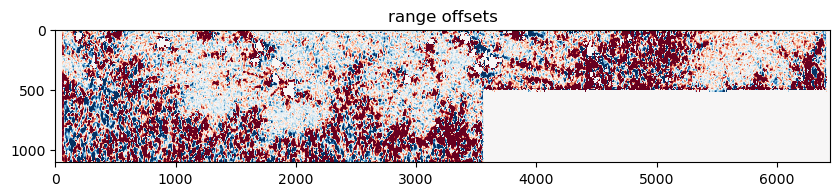

In [10]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.imshow(np.flip(ds.velocity, axis=1), vmin=-20, vmax=20, cmap='RdBu_r', interpolation='none')
ax.set_title('range offsets')
ax.set_aspect('equal')